<a href="https://colab.research.google.com/github/ritwiks9635/Generative_Model/blob/main/High_Resolution_Image_Generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**💫📸Low to High Resolution Image🌟📸**

[Dataset](https://www.kaggle.com/datasets/soumikrakshit/lol-dataset)

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/soumikrakshit/lol-dataset/lol-dataset.zip

Archive:  /content/https:/www.kaggle.com/datasets/soumikrakshit/lol-dataset/lol-dataset.zip
  inflating: lol_dataset/eval15/high/1.png  
  inflating: lol_dataset/eval15/high/111.png  
  inflating: lol_dataset/eval15/high/146.png  
  inflating: lol_dataset/eval15/high/179.png  
  inflating: lol_dataset/eval15/high/22.png  
  inflating: lol_dataset/eval15/high/23.png  
  inflating: lol_dataset/eval15/high/493.png  
  inflating: lol_dataset/eval15/high/547.png  
  inflating: lol_dataset/eval15/high/55.png  
  inflating: lol_dataset/eval15/high/665.png  
  inflating: lol_dataset/eval15/high/669.png  
  inflating: lol_dataset/eval15/high/748.png  
  inflating: lol_dataset/eval15/high/778.png  
  inflating: lol_dataset/eval15/high/780.png  
  inflating: lol_dataset/eval15/high/79.png  
  inflating: lol_dataset/eval15/low/1.png  
  inflating: lol_dataset/eval15/low/111.png  
  inflating: lol_dataset/eval15/low/146.png  
  inflating: lol_dataset/eval15/low/179.png  
  inflating: lol_dataset/ev

In [ ]:
!rm -r /content/https:

In [ ]:
import random
random.seed(10)
import numpy as np
from glob import glob

from PIL import Image,  ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
data_dir = "/content/lol_dataset"
print(os.listdir(data_dir))
print("Total Images :: ", len(os.listdir(data_dir + "/our485" + "/low")))
print("Total Test Images :: ", len(os.listdir(data_dir + "/eval15" + "/low")))

['our485', 'eval15']
Total Images ::  485
Total Test Images ::  15


In [ ]:
image_size = 128
batch_size = 4
train_samples = 300

In [ ]:
def load_images(img_path):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_png(image, channels = 3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, tf.float32) / 255.0
    return image

def image_crop(low_img, high_img):
    low_img_shape = tf.shape(low_img)[:2]
    low_w = tf.random.uniform(shape = (), maxval = low_img_shape[1] - image_size + 1, dtype = tf.int32)
    low_h = tf.random.uniform(shape = (), maxval = low_img_shape[0] - image_size + 1, dtype = tf.int32)
    low_img_crop = low_img[low_h : low_h + image_size, low_w : low_w + image_size]
    high_img_crop = high_img[low_h : low_h + image_size, low_w : low_w + image_size]

    low_img_crop.set_shape([image_size, image_size, 3])
    high_img_crop.set_shape([image_size, image_size, 3])
    return low_img_crop, high_img_crop

def preprocess_data(low_image_path, high_image_path):
    low_image = load_images(low_image_path)
    high_image = load_images(high_image_path)
    low_image, high_image = image_crop(low_image, high_image)
    return low_image, high_image

def build_dataset(low_images, high_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_images, high_images))
    dataset = dataset.map(preprocess_data, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder = True)
    return dataset

In [ ]:
train_low_light_images = sorted(glob("/content/lol_dataset/our485/low/*"))[: train_samples]
train_high_light_images = sorted(glob("/content/lol_dataset/our485/high/*"))[: train_samples]

val_low_light_images = sorted(glob("/content/lol_dataset/our485/low/*"))[train_samples :]
val_high_light_images = sorted(glob("/content/lol_dataset/our485/high/*"))[train_samples :]

test_low_light_images = sorted(glob("/content/lol_dataset/eval15/low/*"))
test_high_light_images = sorted(glob("/content/lol_dataset/eval15/high/*"))

train_dataset = build_dataset(train_low_light_images, train_high_light_images)
valid_dataset = build_dataset(val_low_light_images, val_high_light_images)

print("Train Dataset:", train_dataset.element_spec)
print("Val Dataset:", valid_dataset.element_spec)

Train Dataset: (TensorSpec(shape=(4, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 128, 128, 3), dtype=tf.float32, name=None))
Val Dataset: (TensorSpec(shape=(4, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 128, 128, 3), dtype=tf.float32, name=None))


## MIRNet Model

Here are the main features of the MIRNet model:

- A feature extraction model that computes a complementary set of features across multiple
spatial scales, while maintaining the original high-resolution features to preserve
precise spatial details.
- A regularly repeated mechanism for information exchange, where the features across
multi-resolution branches are progressively fused together for improved representation
learning.
- A new approach to fuse multi-scale features using a selective kernel network
that dynamically combines variable receptive fields and faithfully preserves
the original feature information at each spatial resolution.
- A recursive residual design that progressively breaks down the input signal
in order to simplify the overall learning process, and allows the construction
of very deep networks.


![](https://raw.githubusercontent.com/soumik12345/MIRNet/master/assets/mirnet_architecture.png)


### Selective Kernel Feature Fusion

The Selective Kernel Feature Fusion or SKFF module performs dynamic adjustment of
receptive fields via two operations: **Fuse** and **Select**. The Fuse operator generates
global feature descriptors by combining the information from multi-resolution streams.
The Select operator uses these descriptors to recalibrate the feature maps (of different
streams) followed by their aggregation.

**Fuse**: The SKFF receives inputs from three parallel convolution streams carrying
different scales of information. We first combine these multi-scale features using an
element-wise sum, on which we apply Global Average Pooling (GAP) across the spatial
dimension. Next, we apply a channel- downscaling convolution layer to generate a compact
feature representation which passes through three parallel channel-upscaling convolution
layers (one for each resolution stream) and provides us with three feature descriptors.

**Select**: This operator applies the softmax function to the feature descriptors to
obtain the corresponding activations that are used to adaptively recalibrate multi-scale
feature maps. The aggregated features are defined as the sum of product of the corresponding
multi-scale feature and the feature descriptor.

![](https://i.imgur.com/7U6ixF6.png)

In [ ]:
def selective_kernel_feature_fusion(multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3):
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = layers.Add()([multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3])
    gap = layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = layers.Reshape((1, 1, channels))(gap)
    compact_feature_representation = layers.Conv2D(filters=channels // 8, kernel_size=(1, 1), activation="relu")(channel_wise_statistics)
    feature_descriptor_1 = layers.Conv2D(channels, kernel_size=(1, 1), activation="softmax")(compact_feature_representation)
    feature_descriptor_2 = layers.Conv2D(channels, kernel_size=(1, 1), activation="softmax")(compact_feature_representation)
    feature_descriptor_3 = layers.Conv2D(channels, kernel_size=(1, 1), activation="softmax")(compact_feature_representation)
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    aggregated_feature = layers.Add()([feature_1, feature_2, feature_3])
    return aggregated_feature

### Dual Attention Unit

The Dual Attention Unit or DAU is used to extract features in the convolutional streams.
While the SKFF block fuses information across multi-resolution branches, we also need a
mechanism to share information within a feature tensor, both along the spatial and the
channel dimensions which is done by the DAU block. The DAU suppresses less useful
features and only allows more informative ones to pass further. This feature
recalibration is achieved by using **Channel Attention** and **Spatial Attention**
mechanisms.

The **Channel Attention** branch exploits the inter-channel relationships of the
convolutional feature maps by applying squeeze and excitation operations. Given a feature
map, the squeeze operation applies Global Average Pooling across spatial dimensions to
encode global context, thus yielding a feature descriptor. The excitation operator passes
this feature descriptor through two convolutional layers followed by the sigmoid gating
and generates activations. Finally, the output of Channel Attention branch is obtained by
rescaling the input feature map with the output activations.

The **Spatial Attention** branch is designed to exploit the inter-spatial dependencies of
convolutional features. The goal of Spatial Attention is to generate a spatial attention
map and use it to recalibrate the incoming features. To generate the spatial attention
map, the Spatial Attention branch first independently applies Global Average Pooling and
Max Pooling operations on input features along the channel dimensions and concatenates
the outputs to form a resultant feature map which is then passed through a convolution
and sigmoid activation to obtain the spatial attention map. This spatial attention map is
then used to rescale the input feature map.

![](https://i.imgur.com/Dl0IwQs.png)

In [ ]:
class ChannelPooling(layers.Layer):
    def __init__(self, axis=-1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.axis = axis
        self.concat = layers.Concatenate(axis=self.axis)

    def call(self, inputs):
        average_pooling = tf.expand_dims(tf.reduce_mean(inputs, axis=-1), axis=-1)
        max_pooling = tf.expand_dims(tf.reduce_max(inputs, axis=-1), axis=-1)
        return self.concat([average_pooling, max_pooling])

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})


def spatial_attention_block(input_tensor):
    compressed_feature_map = ChannelPooling(axis=-1)(input_tensor)
    feature_map = layers.Conv2D(1, kernel_size=(1, 1))(compressed_feature_map)
    feature_map = keras.activations.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    average_pooling = layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = layers.Reshape((1, 1, channels))(average_pooling)
    feature_activations = layers.Conv2D(filters=channels // 8, kernel_size=(1, 1), activation="relu")(feature_descriptor)
    feature_activations = layers.Conv2D(filters=channels, kernel_size=(1, 1), activation="sigmoid")(feature_activations)
    return input_tensor * feature_activations


def dual_attention_unit_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same", activation="relu")(input_tensor)
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(feature_map)
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return layers.Add()([input_tensor, concatenation])

### Multi-Scale Residual Block

The Multi-Scale Residual Block is capable of generating a spatially-precise output by
maintaining high-resolution representations, while receiving rich contextual information
from low-resolutions. The MRB consists of multiple (three in this paper)
fully-convolutional streams connected in parallel. It allows information exchange across
parallel streams in order to consolidate the high-resolution features with the help of
low-resolution features, and vice versa. The MIRNet employs a recursive residual design
(with skip connections) to ease the flow of information during the learning process. In
order to maintain the residual nature of our architecture, residual resizing modules are
used to perform downsampling and upsampling operations that are used in the Multi-scale
Residual Block.

![](https://i.imgur.com/wzZKV57.png)

In [ ]:
# Recursive Residual Modules


def down_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(input_tensor)
    main_branch = layers.Conv2D(channels, kernel_size=(3, 3), padding="same", activation="relu")(main_branch)
    main_branch = layers.MaxPooling2D()(main_branch)
    main_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.MaxPooling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


def up_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(input_tensor)
    main_branch = layers.Conv2D(channels, kernel_size=(3, 3), padding="same", activation="relu")(main_branch)
    main_branch = layers.UpSampling2D()(main_branch)
    main_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.UpSampling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


# MRB Block
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    # SKFF
    level1_skff = selective_kernel_feature_fusion(
        level1_dau,
        up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau)),
    )
    level2_skff = selective_kernel_feature_fusion(
        down_sampling_module(level1_dau),
        level2_dau,
        up_sampling_module(level3_dau),
    )
    level3_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau),
        level3_dau,
    )
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(
        up_sampling_module(dual_attention_unit_block(level3_skff))
    )
    # SKFF 2
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level2_dau_2, level3_dau_2)
    conv = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(skff_)
    return layers.Add()([input_tensor, conv])

In [ ]:
def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(conv1)
    return layers.Add()([conv2, input_tensor])


def mirnet_model(num_rrg, num_mrb, channels):
    input_tensor = keras.Input(shape=[None, None, 3])
    x1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(x1)
    output_tensor = layers.Add()([input_tensor, conv])
    return keras.Model(input_tensor, output_tensor)


model = mirnet_model(num_rrg=3, num_mrb=2, channels=64)

## Training

- We train MIRNet using **Charbonnier Loss** as the loss function and **Adam
Optimizer** with a learning rate of `1e-4`.
- We use **Peak Signal Noise Ratio** or PSNR as a metric which is an expression for the
ratio between the maximum possible value (power) of a signal and the power of distorting
noise that affects the quality of its representation.

In [ ]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer = optimizer,
    loss = charbonnier_loss,
    metrics = [peak_signal_noise_ratio])

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = "val_peak_signal_noise_ratio",
    patience = 5,
    factor = 0.5,
    verbose = 1,
    min_delta = 1e-7,
    mode = "max")

Epoch 1/50
3/3 [==============================] - 299s 13s/step - loss: 0.3104 - peak_signal_noise_ratio: 58.0705 - val_loss: 0.1754 - val_peak_signal_noise_ratio: 63.2168 - lr: 1.0000e-04
Epoch 2/50
3/3 [==============================] - 24s 11s/step - loss: 0.1512 - peak_signal_noise_ratio: 63.8712 - val_loss: 0.1682 - val_peak_signal_noise_ratio: 63.4792 - lr: 1.0000e-04
Epoch 3/50
3/3 [==============================] - 24s 11s/step - loss: 0.2018 - peak_signal_noise_ratio: 62.0549 - val_loss: 0.1667 - val_peak_signal_noise_ratio: 63.4701 - lr: 1.0000e-04
Epoch 4/50
3/3 [==============================] - 24s 11s/step - loss: 0.1690 - peak_signal_noise_ratio: 62.9719 - val_loss: 0.1524 - val_peak_signal_noise_ratio: 64.3822 - lr: 1.0000e-04
Epoch 5/50
3/3 [==============================] - 19s 9s/step - loss: 0.1399 - peak_signal_noise_ratio: 64.5414 - val_loss: 0.1502 - val_peak_signal_noise_ratio: 64.4471 - lr: 1.0000e-04
Epoch 6/50
3/3 [==============================] - 24s 11s/st

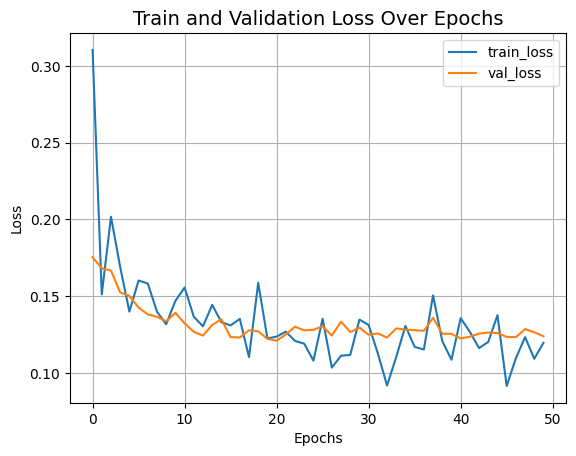

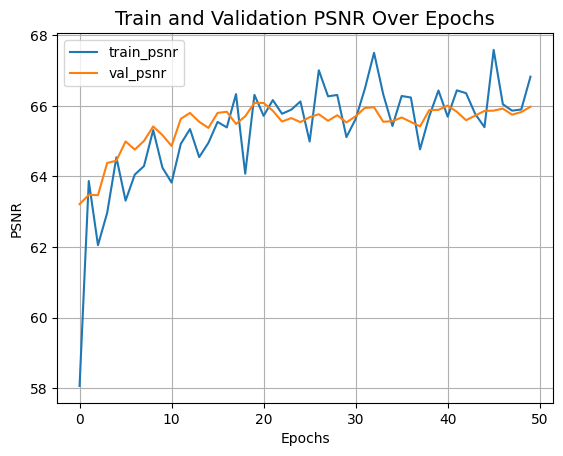

In [ ]:
history = model.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = 50,
    callbacks = [reduce_lr])


def plot_history(value, name):
    plt.plot(history.history[value], label=f"train_{name.lower()}")
    plt.plot(history.history[f"val_{value}"], label=f"val_{name.lower()}")
    plt.xlabel("Epochs")
    plt.ylabel(name)
    plt.title(f"Train and Validation {name} Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss", "Loss")
plot_history("peak_signal_noise_ratio", "PSNR")

In [ ]:
def plot_predictions(images, title):
    fig = plt.figure(figsize=(20, 12))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.title(title)
        plt.imshow(images[i])
        plt.axis("off")

    plt.show()


def prediction(new_images):
    img = keras.utils.img_to_array(new_images)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis = 0)
    pred = model.predict(img, verbose = 0)
    pred_img = pred[0] * 255.0
    pred_img = pred_img.clip(0, 255)
    pred_img = pred_img.reshape((np.shape(pred_img)[0], np.shape(pred_img)[1], 3))
    pred_img = Image.fromarray(np.uint8(pred_img))
   # new_images = Image.fromarray(np.uint8(new_images))
    return pred_img

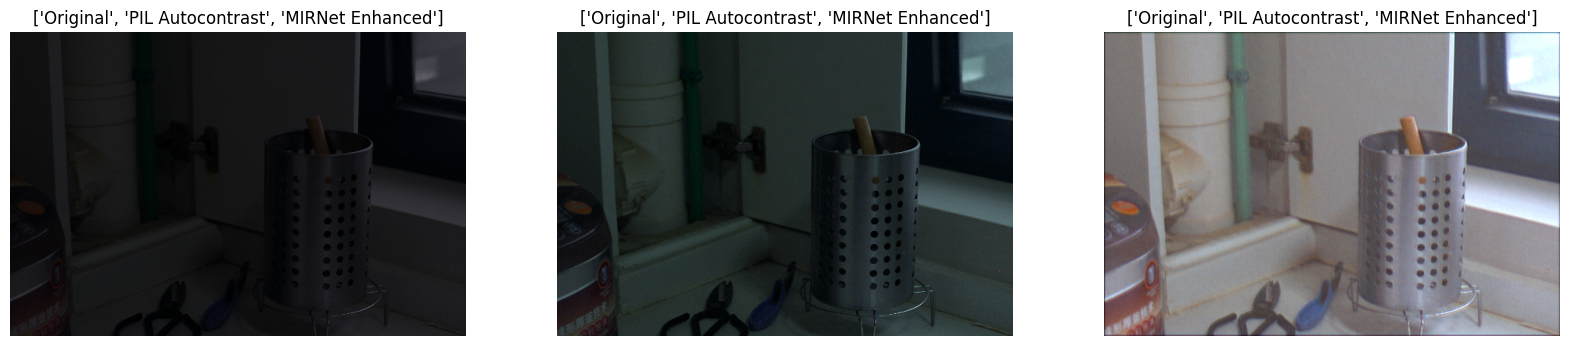

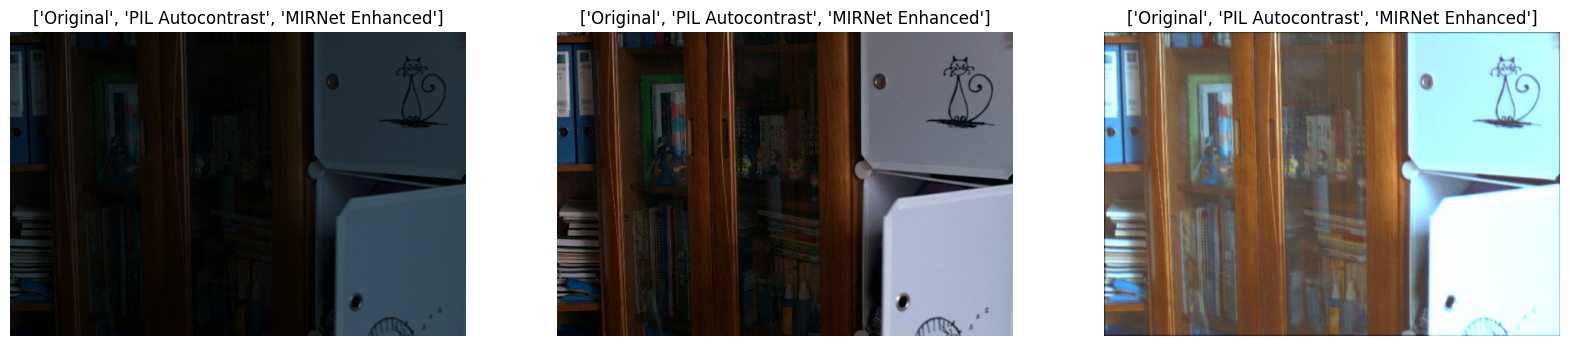

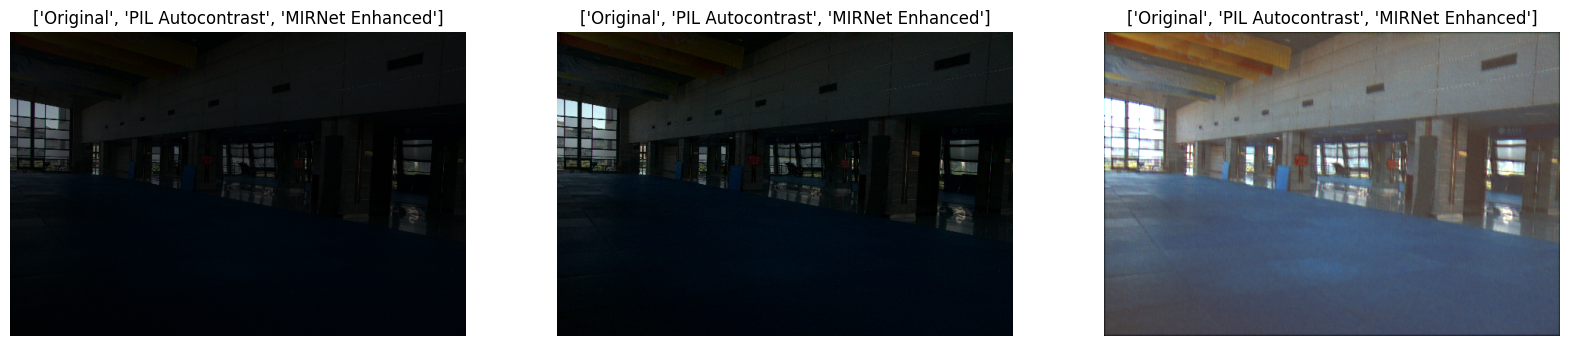

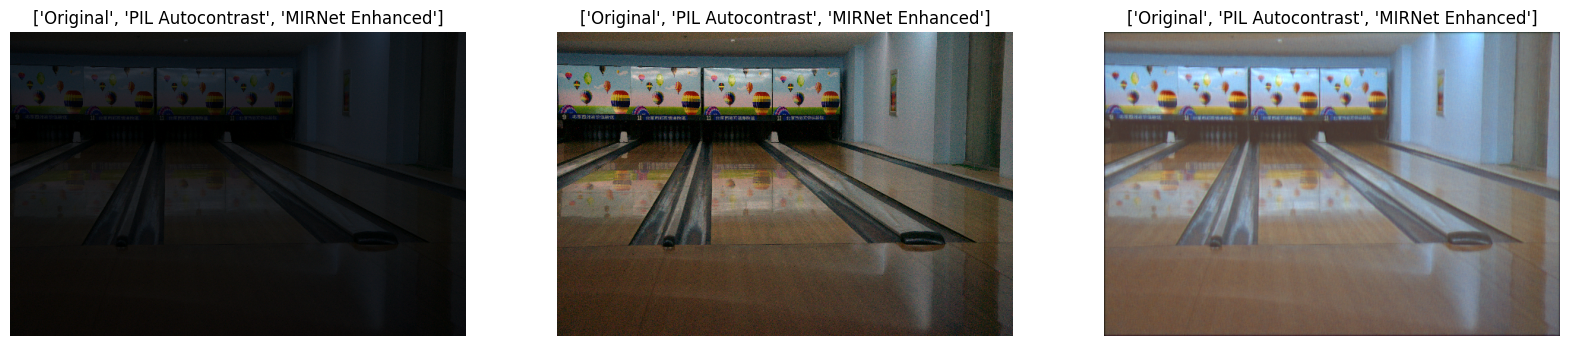

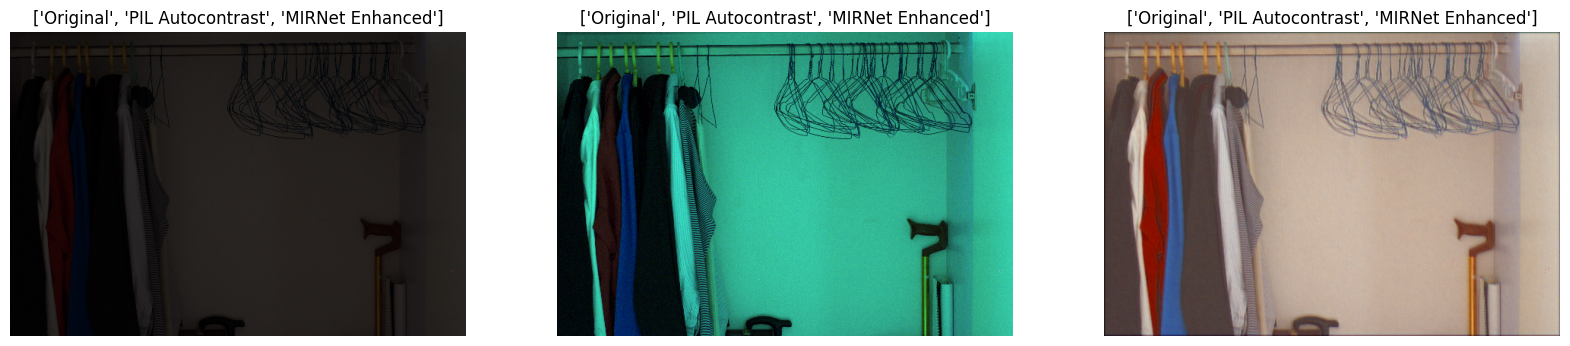

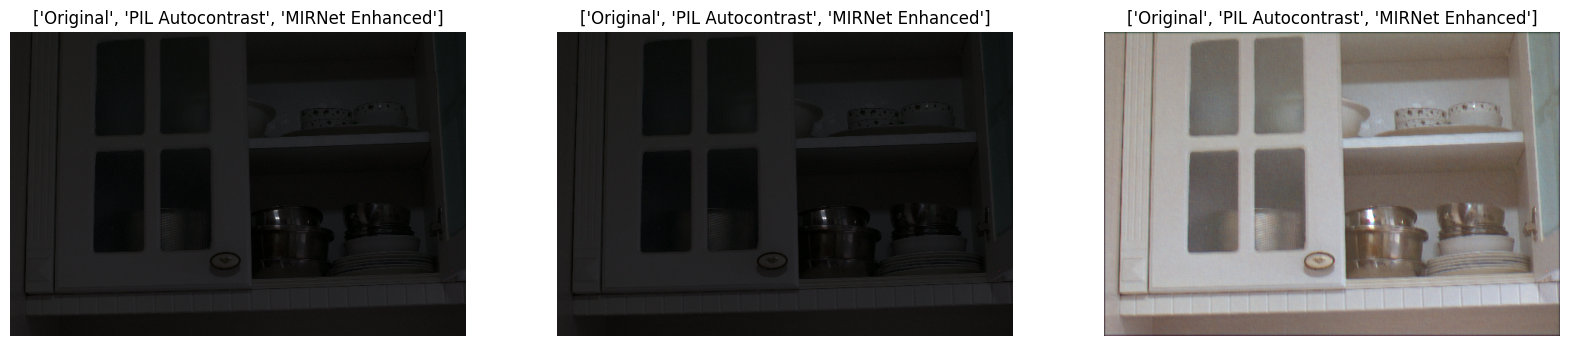

In [ ]:
for low_light_image in random.sample(test_low_light_images, 6):
    original_image = Image.open(low_light_image)
    pred_image = prediction(original_image)
    plot_predictions(
        [original_image, ImageOps.autocontrast(original_image), pred_image],
        ["Original", "PIL Autocontrast", "MIRNet Enhanced"]
    )